C:\Users\hayyu.ragea\AppData\Local\Temp\ipykernel_28880\1580035764.py:33: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


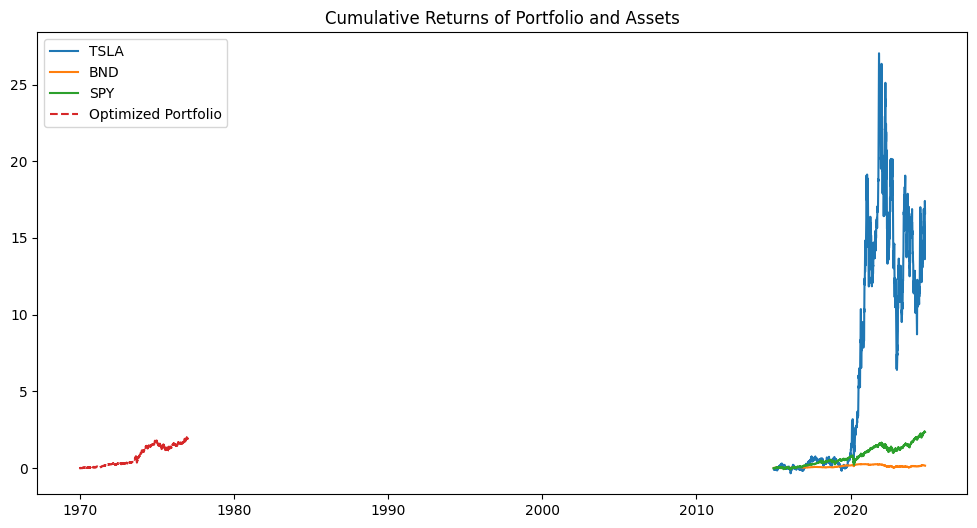

Optimized Portfolio Weights:  [0.12809812 0.48966153 0.38224035]
Portfolio Return:  0.11466907742656107
Portfolio Volatility:  0.12330126380755345
Portfolio Sharpe Ratio:  0.9299910956755046
Value at Risk (VaR) at 95% Confidence: -0.011890724026681398

Expected Portfolio Performance Summary:
Annual Portfolio Return: 11.47%
Portfolio Volatility (Risk): 12.33%
Sharpe Ratio: 0.93


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

# Data paths
TSLA_PATH = "C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/portfolio-management-optimization/data/TSLA_processed.csv"
BND_PATH = "C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/portfolio-management-optimization/data/BND_processed.csv"
SPY_PATH = "C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/portfolio-management-optimization/data/SPY_processed.csv"

# Fetch and preprocess data
tsla_data = pd.read_csv(TSLA_PATH, parse_dates=['Date'], index_col='Date')
bnd_data = pd.read_csv(BND_PATH, parse_dates=['Date'], index_col='Date')
spy_data = pd.read_csv(SPY_PATH, parse_dates=['Date'], index_col='Date')

# Ensure the frequency is set for time series data (important for ARIMA)
bnd_data = bnd_data.asfreq('B')  # Business day frequency
spy_data = spy_data.asfreq('B')

# Merge all data into one DataFrame
data = pd.DataFrame({
    'TSLA': tsla_data['Adj Close'],
    'BND': bnd_data['Adj Close'],
    'SPY': spy_data['Adj Close']
})

# Calculate daily returns
returns = data.pct_change().dropna()

# Forecast BND and SPY using ARIMA
def forecast_arima(data, steps=30):
    model = ARIMA(data, order=(5,1,0))  # Example ARIMA model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

# Forecast BND and SPY (forecasting next 30 days)
bnd_forecast = forecast_arima(bnd_data['Adj Close'], steps=30)
spy_forecast = forecast_arima(spy_data['Adj Close'], steps=30)

# Add forecasted values to the original data
forecast_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_data = pd.DataFrame({
    'TSLA': tsla_data['Adj Close'][-30:],  # Assuming you have already forecasted TSLA from Task 3
    'BND': bnd_forecast,
    'SPY': spy_forecast
}, index=forecast_dates)

data = pd.concat([data, forecast_data])

# Portfolio Analysis
# Compute the annual return
annual_return = returns.mean() * 252  # 252 trading days in a year

# Compute the covariance matrix
cov_matrix = returns.cov() * 252  # Annualize covariance

# Portfolio Optimization - Maximizing the Sharpe Ratio
def calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negative for minimization

# Portfolio optimization function
def optimize_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
    bounds = tuple((0, 1) for asset in range(num_assets))  # Weights between 0 and 1
    result = minimize(calculate_sharpe_ratio, num_assets * [1. / num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Get optimized portfolio weights
optimized_weights = optimize_portfolio(annual_return, cov_matrix)

# Portfolio performance metrics
portfolio_return = np.dot(optimized_weights, annual_return)
portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
sharpe_ratio = portfolio_return / portfolio_volatility

# Visualize Portfolio Performance
cumulative_returns = (returns + 1).cumprod() - 1
portfolio_cumulative_return = (np.dot(returns, optimized_weights) + 1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns['TSLA'], label='TSLA')
plt.plot(cumulative_returns['BND'], label='BND')
plt.plot(cumulative_returns['SPY'], label='SPY')
plt.plot(portfolio_cumulative_return, label='Optimized Portfolio', linestyle='--')
plt.legend()
plt.title('Cumulative Returns of Portfolio and Assets')
plt.show()

# Print out results
print("Optimized Portfolio Weights: ", optimized_weights)
print("Portfolio Return: ", portfolio_return)
print("Portfolio Volatility: ", portfolio_volatility)
print("Portfolio Sharpe Ratio: ", sharpe_ratio)

# Portfolio risk metrics (VaR)
VaR = np.percentile(returns.dot(optimized_weights), 5)  # 5th percentile VaR
print(f"Value at Risk (VaR) at 95% Confidence: {VaR}")

# Summarizing Expected Portfolio Performance
print("\nExpected Portfolio Performance Summary:")
print(f"Annual Portfolio Return: {portfolio_return * 100:.2f}%")
print(f"Portfolio Volatility (Risk): {portfolio_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
